In [31]:
import numpy as np
import sys
import os
import glob
import getpass
import argparse
import pickle
import matplotlib.cm as cm
import pandas as pd
import matplotlib.pyplot as plt
import collections 
def makehash():
    return collections.defaultdict(makehash)
import fnmatch 
import torch 
from tqdm import tqdm 
# from utils import save_dir, analyze_dir, results_dir,train_pool
import scipy.spatial.distance as dist
from tqdm import tqdm
import re
from sklearn.manifold import TSNE

def moving_average(x,w):
    w_min=1#int(np.floor(w/2))
    return pd.Series(x).rolling(w, min_periods=w_min).mean()
av_window=10

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [32]:
save_dir = '/mindhive/evlab/u/Shared/Greta_Eghbal_manifolds/extracted/'
data_dir = '/mindhive/evlab/u/Shared/Greta_Eghbal_manifolds/data/'
analyze_dir = '/mindhive/evlab/u/Shared/Greta_Eghbal_manifolds/analyze/'
results_dir = '/mindhive/evlab/u/Shared/Greta_Eghbal_manifolds/results/'

In [76]:
model_identifier = 'NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.000161_sigma=5.0_nfeat=936-train_test-fixed'
# model_identifier = 'NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.0923671_sigma=5.0_nfeat=936-train_test-fixed'
# model_identifier = 'linear_NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.000161_sigma=5.0_nfeat=936-train_test-fixed'
# model_identifier = 'linear_NN-tree_nclass=64_nobj=64000_nhier=6_beta=0.0923671_sigma=5.0_nfeat=936-train_test-fixed'
train_identifier = 'epochs-10_batch-32_lr-0.01_momentum-0.5_init-gaussian_std-1e-06'
analyze_identifier='mftma-exm_per_class=50-proj=False-rand=True-kappa=1e-08-n_t=300-n_rep=5'
#epochs-10_batch-32_lr-0.001_momentum-0.5_init-gaussian_std-0.0001
#                           epochs-10_batch-32_lr-0.002_momentum-0.6_init-gaussian_std-1e-05 \
#                           epochs-10_batch-32_lr-0.01_momentum-0.5_init-gaussian_std-1e-06 

In [77]:
training_files=[]
for file in os.listdir(os.path.join(save_dir,model_identifier,train_identifier)):
    if fnmatch.fnmatch(file, '*.pth'):
            training_files.append(os.path.join(save_dir,model_identifier,train_identifier,file))

In [78]:
hier_accu=[]
test_predictions=[]
test_probabilites=[]
test_grad_dict=[]
for idx, files in tqdm(enumerate(training_files)):
    test=torch.load(files)
    hier_accu.append([test['epoch'],test['batchidx'], test['hier_test_acc']])
    test_predictions.append([test['target_test'], test['pred_test']])
    test_probabilites.append( test['pred_test_prob'])
    test_grad_dict.append(test['grad_dict'])
    
dummy=[]
epochs=[]
batches=[]
for item in hier_accu:
    epochs.append(item[0])
    batches.append(item[1])
    dummy.append(item[0]*10000+item[1])
fixed_idx=np.argsort(dummy)

1060it [07:21,  2.40it/s]


In [81]:
hier_accu=[hier_accu[x] for x in fixed_idx]
accuracies=np.stack([x[2] for x in hier_accu])
batches=np.stack([x[1] for x in hier_accu])
epochs=np.stack([x[0] for x in hier_accu])

In [82]:
# load distance data (have to run it first)
data_=pickle.load(open(os.path.join(save_dir,analyze_identifier,model_identifier,train_identifier, f'{model_identifier}_distance_pooled_v3.pkl'),'rb'))

# fix any ordering issue 
layer_dist_over_time=[]
epoch_over_time=[]
batch_idx_over_time=[]
for layer in data_['distance_results'].keys():
    hier_distance_over_time=[]
    for hier in data_['distance_results'][layer].keys():
        distance_over_time=[]
        if hier!='epoch':
            for key,item in data_['distance_results'][layer][hier].items():
                distance_over_time.append(item['distance'].mean(axis=1))
            hier_distance_over_time.append(dict(data=np.stack(distance_over_time),id=item['identifier']))
    layer_dist_over_time.append(hier_distance_over_time)

In [83]:
seq_keys=list(data_['distance_results']['layer_0_Input'][0].keys())
seq_keys=[x for x in seq_keys if x!='epoch' ]
dist_epochs=[data_['distance_results']['layer_0_Input'][0][x]['epoch'] for x in seq_keys]
dist_batch=[data_['distance_results']['layer_0_Input'][1][x]['batchidx'] for x in seq_keys]

epoch_factor=1e3*np.ceil(np.max(batches)/1e3)
epoch_batch=epoch_factor*epochs+batches
dist_epoch_batch=epoch_factor*np.array(dist_epochs)+np.array(dist_batch)
array_correspondance=[np.argwhere(x==epoch_batch) for x in dist_epoch_batch]
x_bar= np.arange(len(epoch_batch))/len(epoch_batch)
epoch_bar=np.argwhere(np.diff(dist_epochs))/(len(dist_epochs))


In [84]:
len(layer_dist_over_time)

4

/opt/conda/envs/rapids/lib/python3.7/site-packages/ipykernel_launcher.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


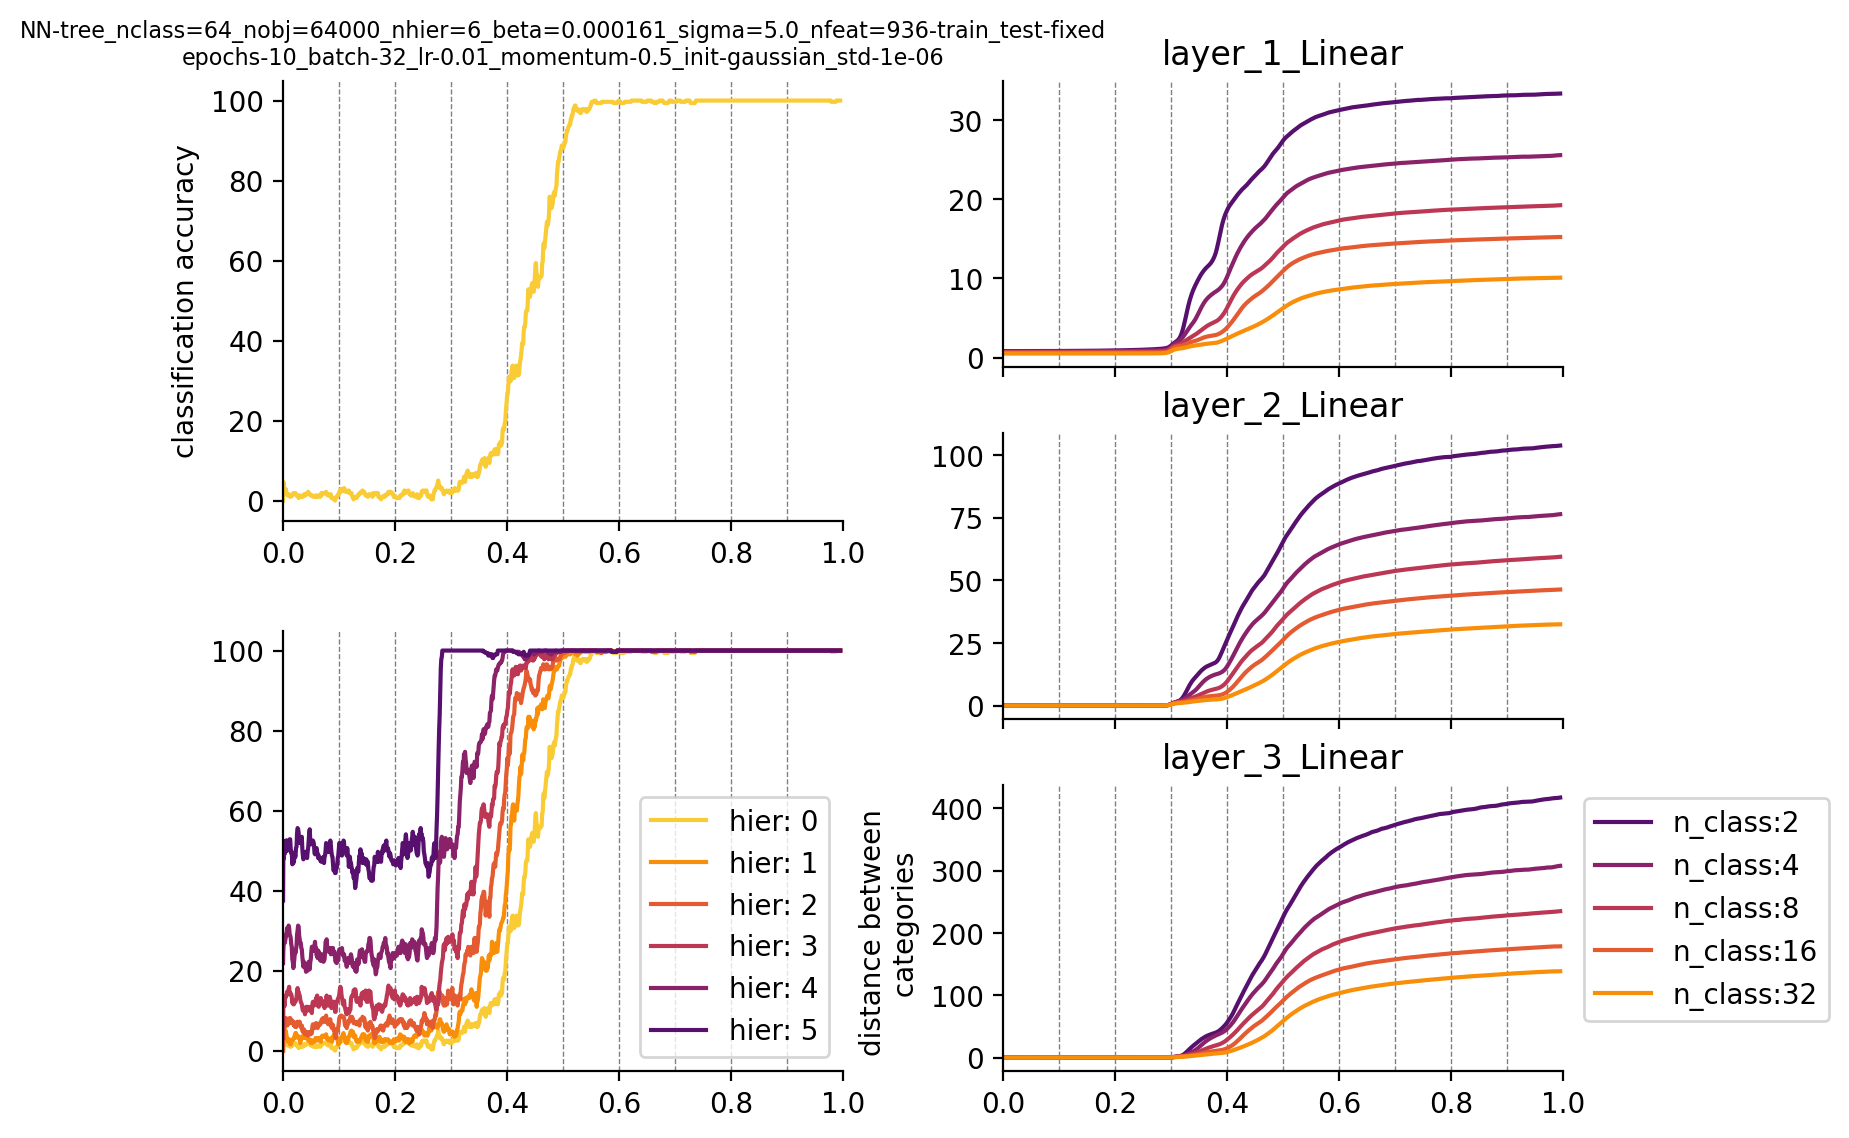

In [85]:
xmin=0
xmax=1
num_colors=accuracies.shape[1]+1
color_fact=num_colors+2
h0=cm.get_cmap('inferno',color_fact)
line_cols=np.flipud(h0(np.arange(color_fact)/color_fact))
line_cols=line_cols[1:,:]

## accuracy ## 
fig=plt.figure(1,figsize=(8,11),dpi=200,frameon=False)
ax1=plt.axes((.05,.7,.35,.2))
ax1.plot(moving_average(x_bar,av_window),moving_average(accuracies[:,0],av_window),label='entities',color=line_cols[0,:])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_ylabel('classification accuracy')
ax1.set_title(f"{model_identifier}\n{train_identifier}",fontsize=8)
ax1.vlines(epoch_bar,ax1.get_ylim()[0],ax1.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax1.autoscale(enable=True, axis='x', tight=True)
ax1.autoscale(enable=True, axis='y', tight=True)
ax1.set_xlim((xmin,xmax))


## hier accuracy ## 
ax2=plt.axes((.05,.45,.35,.2))
for h in range(accuracies.shape[1]):
        ax2.plot(moving_average(x_bar,av_window),moving_average(accuracies[:,h],av_window),label=f'hier: {h}',color=line_cols[h,:])
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.legend()
ax2.vlines(epoch_bar,ax2.get_ylim()[0],ax2.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax2.autoscale(enable=True, axis='x', tight=True)
ax2.autoscale(enable=True, axis='y', tight=True)
ax2.set_xlim((xmin,xmax))

## distance layer 1 ## 
ax3=plt.axes((.5,.77,.35,.13))
k=1 # layer 1
layer_data=layer_dist_over_time[k]
for h, hier_data in enumerate(layer_data):
    distance_data=hier_data['data'].mean(axis=1)
    corrected_data=list(np.empty(epoch_batch.shape)*np.NaN)
    for idx, x in enumerate(array_correspondance):
        corrected_data[int(x)]=distance_data[idx]

    ax3.plot(moving_average(x_bar,av_window),moving_average(corrected_data,av_window),label=f"n_class:{hier_data['data'].shape[1]}",color=line_cols[len(layer_data)-h,:])

# INPUT
# k=0 # layer 1
# layer_data=layer_dist_over_time[k]
# for h, hier_data in enumerate(layer_data):
#     distance_data=hier_data['data'].mean(axis=1)
#     corrected_data=list(np.empty(epoch_batch.shape)*np.NaN)
#     for idx, x in enumerate(array_correspondance):
#         corrected_data[int(x)]=distance_data[idx]

#     ax3.plot(moving_average(x_bar,av_window),moving_average(corrected_data,av_window),label=f"n_class:{hier_data['data'].shape[1]}",color=line_cols[len(layer_data)-h,:])


ax3.set_title(f"{list(data_['distance_results'].keys())[k]}")
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.axes.xaxis.set_ticklabels([])
ax3.vlines(epoch_bar,ax3.get_ylim()[0],ax3.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax3.autoscale(enable=True, axis='x', tight=True)
ax3.autoscale(enable=True, axis='y', tight=True)
ax3.set_xlim((xmin,xmax))

## distance layer 2 ## 
ax4=plt.axes((.5,.61,.35,.13))
k=2
layer_data=layer_dist_over_time[k]
for h, hier_data in enumerate(layer_data):
    distance_data=hier_data['data'].mean(axis=1)
    corrected_data=list(np.empty(epoch_batch.shape)*np.NaN)
    for idx, x in enumerate(array_correspondance):
        corrected_data[int(x)]=distance_data[idx]

    ax4.plot(moving_average(x_bar,av_window),moving_average(corrected_data,av_window),label=f"n_class:{hier_data['data'].shape[1]}",color=line_cols[len(layer_data)-h,:])
ax4.set_title(f"{list(data_['distance_results'].keys())[k]}")
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.axes.xaxis.set_ticklabels([])
ax4.vlines(epoch_bar,ax4.get_ylim()[0],ax4.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax4.autoscale(enable=True, axis='x', tight=True)
ax4.autoscale(enable=True, axis='y', tight=True)
ax4.set_xlim((xmin,xmax))


## distance layer 3 ## 
ax5=plt.axes((.5,.45,.35,.13))
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)

k=3
layer_data=layer_dist_over_time[k]
for h, hier_data in enumerate(layer_data):
    distance_data=hier_data['data'].mean(axis=1)
    corrected_data=list(np.empty(epoch_batch.shape)*np.NaN)
    for idx, x in enumerate(array_correspondance):
        corrected_data[int(x)]=distance_data[idx]

    ax5.plot(moving_average(x_bar,av_window),moving_average(corrected_data,av_window),label=f"n_class:{hier_data['data'].shape[1]}",color=line_cols[len(layer_data)-h,:])
ax5.set_title(f"{list(data_['distance_results'].keys())[k]}")
ax5.legend(bbox_to_anchor=(1, .5, 0.5, 0.5))
ax5.set_ylabel('distance between \n categories')
ax5.vlines(epoch_bar,ax5.get_ylim()[0],ax5.get_ylim()[1],color=(.5,.5,.5),linestyle='dashed',linewidth=.5)
ax5.autoscale(enable=True, axis='x', tight=True)
ax5.autoscale(enable=True, axis='y', tight=True)
ax5.set_xlim((xmin,xmax))

plt.tight_layout()
plt.show()
fig.savefig(f"{results_dir}/euclidean_{model_identifier}_{train_identifier}_v3.pdf",transparent=True)  



In [86]:
#  for overlay on other plots
d_plot_specs = {'x_bar':x_bar,
               'hier_accu':hier_accu,
                'dist':layer_dist_over_time,
                'arr_':array_correspondance,
               }
with open(os.path.join(analyze_dir, f"d_fig2_plot_specs_{model_identifier}.pkl"), "wb") as output_file:
    pickle.dump(d_plot_specs, output_file)

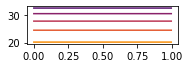

In [87]:
ax3=plt.axes((.5,.77,.35,.13))
k=0 # layer 1
layer_data=layer_dist_over_time[k]
for h, hier_data in enumerate(layer_data):
    distance_data=hier_data['data'].mean(axis=1)
    corrected_data=list(np.empty(epoch_batch.shape)*np.NaN)
    for idx, x in enumerate(array_correspondance):
        corrected_data[int(x)]=distance_data[idx]

    ax3.plot(moving_average(x_bar,av_window),moving_average(corrected_data,av_window),label=f"n_class:{hier_data['data'].shape[1]}",color=line_cols[len(layer_data)-h,:])
